# Production System Assignment

In [1]:
from __future__ import annotations

import random
import statistics
from collections.abc import Callable, Sequence

import numpy as np
import simpy
from scipy import stats
from simpy.events import ProcessGenerator
from lib.server import Server
from lib.job import Job
from matplotlib import pyplot as plt

In [22]:
class System:
    def __init__(
        self,
        env: simpy.Environment,
        inter_arrival_time_distribution: Callable[[], float],
        processing_time_per_family_distribution: list[Callable[[], float]],
        families_distribution: Callable[[], float],
        due_dates_distribution: Callable[[], float],
        routing_distribution: dict[int, list[Callable[[], float]]],
        routing_prob: dict[int, list[float]]
    ) -> None:
        self.env = env
        self.inter_arrival_time_distribution = inter_arrival_time_distribution
        self.processing_time_per_family_distribution = processing_time_per_family_distribution
        self.families_distribution = families_distribution
        self.due_dates_distribution = due_dates_distribution
        self.routing_distribution = routing_distribution
        self.routing_prob = routing_prob

        self.machines: list[Server] = []
        for i in range(6):
            server = Server(self.env, 1, "WC{}".format(i+1))
            self.machines.append(server)

        self.jobs: list[Job] = []

        self.th_stats = [0]
        self.last_total_th = 0

        self.env.process(self.run())
        self.env.process(self.throughput_sampler())

    @property
    def finished_jobs(self) -> int:
        return sum(job.done for job in self.jobs)

    def throughput_sampler(self):
        while True:
            yield self.env.timeout(60)
            delta = self.finished_jobs - self.last_total_th
            self.th_stats.append(delta)
            self.last_total_th = self.finished_jobs

    def run(self) -> ProcessGenerator:
        idx = 0
        while True:
            timeout_inter_arrival = self.inter_arrival_time_distribution()
            weight = self.families_distribution()
            if weight <= 0.1:
                family = 1
            elif weight <= 0.62:
                family = 2
            else:
                family = 3
            processing_time = self.processing_time_per_family_distribution[family-1]()
            due_date_offset = self.due_dates_distribution()

            family_routing_distr = self.routing_distribution[family]
            family_routing_prob = self.routing_prob[family]

            job_routing = []
            for i in range(6):
                if family_routing_distr[i]() <= family_routing_prob[i]:
                    job_routing.append(self.machines[i])

            yield self.env.timeout(timeout_inter_arrival)

            job = Job(
                env=self.env,
                routing=job_routing,
                arrival_time=self.env.now,
                process_time=processing_time,
                due_date=(self.env.now + due_date_offset),
                idx=idx,
                family="F{}".format(family)
            )

            idx += 1
            self.jobs.append(job)
            self.env.process(job.main())

In [23]:
seeds = [random.randint(1, 100000) for _ in range(1000)]

In [34]:
N = 10
M = N + 100

In [25]:
def run_system(seed: int | None, until: float = 60*120) -> System:
    random.seed(seed)
    production_system = System(
        env=simpy.Environment(),
        inter_arrival_time_distribution=lambda: random.expovariate(lambd=0.65),
        processing_time_per_family_distribution=[
            lambda: random.gammavariate(2,2),
            lambda: random.gammavariate(4,0.5),
            lambda: random.gammavariate(6,1/6)
        ],
        families_distribution=lambda: random.random(),
        routing_distribution={
            1: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()],
            2: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()],
            3: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()]
        },
        routing_prob={
            1: [1,1,0,1,1,1],
            2: [0.8, 0.8, 1, 0.8, 0.8, 0.75],
            3: [0,0,1,0,0,0.75]
        },
        due_dates_distribution=lambda: random.uniform(30,50)
    )
    production_system.env.run(until=until)
    return production_system

def main_system(*seeds: int, until) -> list[System]:
    return [run_system(seed, until=until) for seed in seeds]

In [31]:
class Welch:
    def __init__(self, process: np.ndarray, window_size: int, tol: float) -> None:
        self.process = process
        self.window_size = window_size
        self.tol = tol
        self.replications_mean = np.mean(process, axis=0)
        self.averaged_process = self._welch()
        self.diff, self.warmup_period = self._find_steady_state()

    @staticmethod
    def moving_average(arr: np.ndarray, window_size: int) -> np.ndarray:
        weights = np.ones(window_size) / window_size
        return np.convolve(arr, weights, mode="valid")

    def _welch(self) -> np.ndarray:
        averaged_process = []
        for i in range(1, self.replications_mean.shape[0] - self.window_size):
            if i <= self.window_size:
                averaged_process.append(self.replications_mean[: 2 * i - 1].mean())
            else:
                # averaged_process.append(
                #    self.replications_mean[
                #        i - self.window_size // 2 : i + self.window_size // 2
                #    ].mean()
                #)
                averaged_process.append(
                    self.replications_mean[
                        (i - 1 - self.window_size) : (i + self.window_size)
                    ].mean()
                )
        return np.array(averaged_process)

    def _find_steady_state(self) -> tuple[np.ndarray, int]:
        arr = self.averaged_process# self.moving_average(self.averaged_process, self.window_size)
        diff = np.diff(arr.flatten())
        for i, d in enumerate(diff):
            if d < self.tol:
                return diff, i + self.window_size
        return diff, -1

    def plot(self):
        plt.plot(self.averaged_process, label="Averaged Process")
        plt.axvline(
            self.warmup_period,
            color="r",
            linestyle="--",
            label=f"Warmup period: {self.warmup_period}",
        )
        plt.legend(loc="best")
        plt.show()


In [14]:
manufacturing_system = run_system(seed=42)

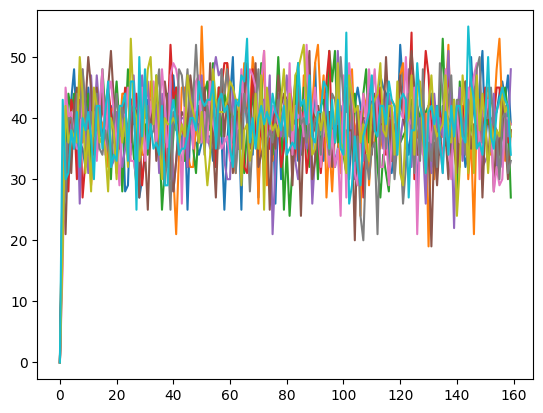

In [32]:
system_runs = main_system(*seeds[:N], until=60 * 160)
system_arr = np.array([run.th_stats for run in system_runs])
plt.plot(system_arr.T)
plt.show()

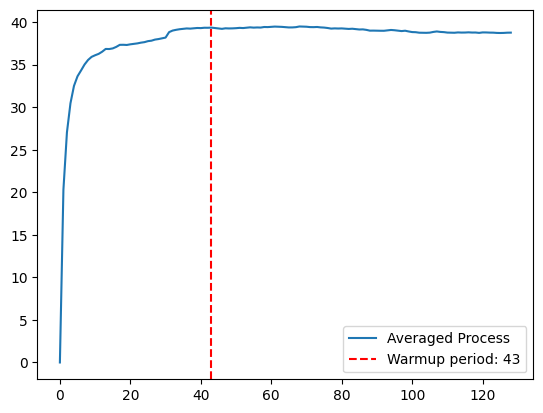

In [33]:
welch = Welch(system_arr, window_size=30, tol=0.1)
welch.plot()

In [15]:
print(f"Jobs: {len(manufacturing_system.jobs)}")
print(f"Finished Jobs: {manufacturing_system.finished_jobs}")

Jobs: 4722
Finished Jobs: 4693


In [16]:
for i, machine in enumerate(manufacturing_system.machines):
    print("machine {} utilization rate: {}".format(i, machine.utilization_rate))
    print("machine {} average queue length: {}".format(i, machine.average_queue_length))

machine 1 utilization rate: 0.7669280825510294
machine 1 average queue length: 1.682568756081408
machine 2 utilization rate: 0.7715931370889199
machine 2 average queue length: 1.5124507121402888
machine 3 utilization rate: 0.9088145076109296
machine 3 average queue length: 6.419781930550185
machine 4 utilization rate: 0.7705765198163053
machine 4 average queue length: 0.9130043291201662
machine 5 utilization rate: 0.7724268230248614
machine 5 average queue length: 1.2547492916966632
machine 6 utilization rate: 0.920030528767812
machine 6 average queue length: 6.26822472812439


In [35]:
def t_student_critical_value(alpha: float, n: int):
    return stats.t.ppf(1 - alpha, n - 1)

In [36]:
def analyze_hourly_throughput(
    runs: Sequence[System], warmup_period: int, alpha: float = 0.05
) -> tuple[float, float, float]:
    n = len(runs)
    sample = [statistics.mean(run.th_stats[warmup_period:]) for run in runs]
    throughput_sample_mean = statistics.mean(sample)
    throughput_sample_variance = statistics.variance(
        sample, xbar=throughput_sample_mean
    )
    t = t_student_critical_value(alpha=alpha, n=n)
    half_interval = t * np.sqrt(throughput_sample_variance / n)
    return throughput_sample_mean, throughput_sample_variance, half_interval

In [37]:
system_runs = main_system(*seeds[N:M], until=60 * 160)
system_arr = np.array([run.th_stats for run in system_runs])
alpha = 0.05
throughput_sample_mean, throughput_sample_variance, half_interval = (
    analyze_hourly_throughput(
        system_runs, warmup_period=welch.warmup_period, alpha=alpha
    )
)
print(f"Throughput Sample Mean: {throughput_sample_mean:.2f}")
print(f"Throughput Sample Variance: {throughput_sample_variance:.2f}")
print(f"Half Interval: {half_interval:.2f}")
print(
    f"Confidence Interval [{alpha=}]: ({throughput_sample_mean - half_interval:.2f}, {throughput_sample_mean + half_interval:.2f})"
)
print(f"Relative Error: {100 * half_interval / throughput_sample_mean:.2f}%")

Throughput Sample Mean: 38.96
Throughput Sample Variance: 0.30
Half Interval: 0.09
Confidence Interval [alpha=0.05]: (38.87, 39.05)
Relative Error: 0.23%
